<a href="https://colab.research.google.com/github/trkfz2/M2020/blob/master/NLP_Assignment__3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf

In [3]:
tf.__version__

'1.15.2'

# Preparing the data



Load the dataset that was prepared in task 1

The original dataset is too large and needs to be reduced. You can for instance:
 - filter out items that have too many or too little tokens
 - select items of a certain type: post, comments or titles
 - or sub sample items randomly






In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

In [0]:
# load data into DataFrame

data = pd.read_csv('drive/My Drive/Manning Project/NLP/stackexchange_812k.tokenized.csv').sample(frac = 1, random_state = 0).reset_index(drop = True)

In [0]:
assert data.shape == (789649, 7), "The dataset does not have the right dimensions"

In [9]:
list(data.columns)

['post_id',
 'parent_id',
 'comment_id',
 'text',
 'category',
 'tokens',
 'n_tokens']

In [0]:
pd.options.display.max_colwidth = 500

In [11]:
# show some examples

data.head()

,post_id,parent_id,comment_id,text,category,tokens,n_tokens
0,298828,NaN,567970.0,"That's not an option atm. This data definitely provides some evidence for length of adherence, I just don't know how to use it.",comment,"that ' s not an option atm . this data definitely provides some evidence for length of adherence , i just don ' t know how to use it .",30
1,142749,142741.0,NaN,"already provided a link to the discussion containing the theoretical aspects. Here is a quick pratical example of how one would do it in R. Please also have a look at these documents which contain the theory as well as examples Simultaneous Inference in General Parametric Models and Additional multcomp Examples . We will use the mtcars dataset and build a linear regression model containing three variables cyl Number of cylinders , disp Displacement and hp Horsepower to predict the variable m...",post,"already provided a link to the discussion containing the theoretical aspects . here is a quick pratical example of how one would do it in r . please also have a look at these documents which contain the theory as well as examples simultaneous inference in general parametric models and additional multcomp examples . we will use the mtcars dataset and build a linear regression model containing three variables cyl number of cylinders , disp displacement and hp horsepower to predict the variable...",332
2,49674,NaN,96088.0,As for I would say this question is off-topic and unlikely to help future visitors interested in statistical science in its theoretical and applied aspects.,comment,as for i would say this question is off - topic and unlikely to help future visitors interested in statistical science in its theoretical and applied aspects .,28
3,264715,NaN,NaN,"I attended a conference on ML and Data Science and I have a general question that was not answered in the conference. If we have a continuous variable, let's say age. What is the best way to handle this variable. These are my thoughts, please let me know if they nonsense, but in general I think it is a very important and useful topic that has not been discussed in the detail that I need it How should you decide on the number of bins? Would it be best to choose an arbitrary number of bins and...",post,"i attended a conference on ml and data science and i have a general question that was not answered in the conference . if we have a continuous variable , let ' s say age . what is the best way to handle this variable . these are my thoughts , please let me know if they nonsense , but in general i think it is a very important and useful topic that has not been discussed in the detail that i need it how should you decide on the number of bins ? would it be best to choose an arbitrary number of...",258
4,45344,NaN,88126.0,"Oh well, I actually meant equivalence in terms of only observed variables -- essentially maxing or more commonly, marginalizing out latent variables and then establishing equivalence.",comment,"oh well , i actually meant equivalence in terms of only observed variables -- essentially maxing or more commonly , marginalizing out latent variables and then establishing equivalence .",29


**Training set**

In [12]:
list(data['category'].unique())

['comment', 'post', 'title']

In [0]:
# trainign set will consist of comments and posts

training = data[data.category.isin(["post","comment"]) ]

In [14]:
training.shape

(705964, 7)

In [15]:
training.category.value_counts()

comment    540587
post       165377
Name: category, dtype: int64

In [16]:
print("Number of tokens per post or comment")

print("Minimum: {}".format(training['n_tokens'].min()))
print("Maximum: {}".format(training['n_tokens'].max()))

print("Average: {:.2f}".format(training['n_tokens'].mean()))
print("Median: {}".format(training['n_tokens'].median()))

Number of tokens per post or comment
Minimum: 5
Maximum: 4903
Average: 67.59
Median: 42.0


In [17]:
print("Number of posts or comments with more than:")
print("100 tokens:{}".format(training['n_tokens'].apply(lambda x: x > 100).sum()))

print("500 tokens:{}".format(training['n_tokens'].apply(lambda x: x > 500).sum()))

print("1000 tokens:{}".format(training['n_tokens'].apply(lambda x: x > 1000).sum()))

Number of posts or comments with more than:
100 tokens:117479
500 tokens:5517
1000 tokens:674


In [18]:
print("Percentage of posts or comments with more than:")
print("100 tokens:{:.2F}%".format(
    training['n_tokens'].apply(lambda x: x > 100).sum()/training.shape[0]*100))

print("500 tokens:{:.2F}%".format(
    training['n_tokens'].apply(lambda x: x > 500).sum()/training.shape[0]*100))

print("1000 tokens:{:.2F}%".format(
    training['n_tokens'].apply(lambda x: x > 1000).sum()/training.shape[0]*100))

Percentage of posts or comments with more than:
100 tokens:16.64%
500 tokens:0.78%
1000 tokens:0.10%


In [19]:
print("Number of posts or comments with less than:")
print("20 tokens: {}".format(training['n_tokens'].apply(lambda x: x <20).sum()))

print("10 tokens: {}".format(training['n_tokens'].apply(lambda x: x < 10).sum()))

print("6 tokens: {}".format(training['n_tokens'].apply(lambda x: x < 6).sum()))

Number of posts or comments with less than:
20 tokens: 150907
10 tokens: 41664
6 tokens: 6232


In [20]:
print("Percentage of posts or comments with less than:")
print("20 tokens:{:.2F}%".format(training['n_tokens'].apply(lambda x: x < 20).sum()/training.shape[0]))

print("10 tokens:{:.2F}%".format(training['n_tokens'].apply(lambda x: x <10).sum()/training.shape[0]))

print("6 tokens:{:.2F}%".format(training['n_tokens'].apply(lambda x: x < 6).sum()/training.shape[0]))

Percentage of posts or comments with less than:
20 tokens:0.21%
10 tokens:0.06%
6 tokens:0.01%


Remove some posts/comments

In [0]:
# keep only posts and comments with the number of tokens between 20 and 100

training_reduced = training[(training['n_tokens'] < 100) & (training['n_tokens'] >= 20)]

In [22]:
training_reduced.shape

(435313, 7)

In [23]:
training_reduced.shape[0]/training.shape[0]

0.6166220940444556

In [24]:
training.category.value_counts()

comment    540587
post       165377
Name: category, dtype: int64

In [25]:
training_reduced.category.value_counts()

comment    368925
post        66388
Name: category, dtype: int64

**Testing set**




In [0]:
# for testing will use only titles

testing = data[data.category == 'title']

In [27]:
testing.shape

(83685, 7)

-----


Build the vocabulary as the set of all unique tokens to construct the list of token indexes.

Filtering on token frequency is one way to reduce the overall size of the vocabulary.



In [28]:
!pip install --upgrade nltk

     |████████████████████████████████| 1.5MB 6.7MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=d6696f62b2db2e761d0c4892013c140cc7817ee2051de1a55402100feccb3aff
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [29]:
import nltk
nltk.__version__

'3.4.5'

In [30]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt


      Unzipping tokenizers/punkt.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [0]:
# we only need tokens for training

training_tokens  = training_reduced['tokens']

In [32]:
len(training_tokens)

435313

In [0]:
from nltk import tokenize
from nltk.tokenize import sent_tokenize

In [0]:
# split comments and posts into a list of sentences

train_text = [list(tokenize.sent_tokenize(item)) for item in training_tokens]

In [35]:
#show some examples 

train_text[0:2]

[["that ' s not an option atm .",
  "this data definitely provides some evidence for length of adherence , i just don ' t know how to use it ."],
 ['as for i would say this question is off - topic and unlikely to help future visitors interested in statistical science in its theoretical and applied aspects .']]

In [0]:
from nltk.lm.preprocessing import flatten

In [0]:
# flatten rows into a single file

flat_rows = list(flatten(train_text))

In [38]:
len(flat_rows)

1304131

In [39]:
# every item is a sentence

flat_rows[100:110]

['the comment by was directed at experienced statisticians who have been taught to use parameter to refer to hypothetical properties of a probability model and other words like characteristics or observations to refer to the things you measure and record .',
 'so it is really dependent on mdp because there is another proof in this book dynamic programming and markov processes by howard for completely ergodic systems in the finite horizon .',
 "and ... the answer in the mentioned link wasn ' t covering my problem !",
 'given a sample of data that contains only the score frequency distribution for scores below a certain threshold , is it possible to fit a complete normal distribution so to estimate what the will be the frequency for scores above the threshold .',
 'good try .',
 "you can fix the problem by using in doing so i believe you ' ll discover that for this result to be true , an additional assumption about the distribution is needed namely , that it has an expectation and the ex

In [0]:
# get the length of sentences

sent_length = [len(item) for item in flat_rows]

In [41]:
max(sent_length)

1042

In [42]:
min(sent_length)

1

In [0]:
from collections import Counter

# count the number of sentences given the length

sent_length_count = Counter(len(item) for item in flat_rows)

In [0]:
sorted(sent_length_count)

In [121]:
# show length counts
i = 0
for  k, v in sent_length_count.items():
  print(k, ":", v)
  i +=1
  if i>10:
    break

28 : 9177
105 : 6752
159 : 2731
186 : 1550
115 : 6048
88 : 8209
153 : 3102
74 : 9262
61 : 9975
166 : 2387
96 : 7424


In [0]:
# how many sentences have less than 5 tokens?

short_sent = [item for item in flat_rows if len(item) < 5]

In [49]:
len(short_sent)

58422

In [51]:
# show some examples of short sentences

short_sent[0:30]

['e .',
 'cf .',
 'c -.',
 'g .',
 'e .',
 'g .',
 'g .',
 'e .',
 '.',
 'see',
 'g .',
 '?',
 '?',
 'i .',
 '?',
 'e .',
 ', .',
 'g .',
 'g .',
 'here',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '?',
 'e .',
 'e .',
 '.']

In [0]:
# keep only sentences with number of tokens between 5 and 50

flat_rows_reduced = [item for item in flat_rows if len(item)<=50 and len(item)>=5]

In [53]:
len(flat_rows), len(flat_rows_reduced)

(1304131, 383313)

-----


In [0]:
def save_to_drive(x, file_name, folder):
  import pickle, os
  save_path = os.path.join('drive/My Drive/', folder, file_name + '.pickle')
  print(save_path)
  
  with open(save_path, 'wb') as handle:
    pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
def load_from_drive(file_name, folder):
  import pickle, os
  load_path = os.path.join('drive/My Drive/', folder, file_name + '.pickle')
  print(load_path)
  
  with open(load_path, 'rb') as handle:
    return pickle.load(handle)


# Sequences

Set a fixed sequence length and build sequences of token indexes from the corpus. (see for instance keras pad_sequences)



Split the sequences into predictors and labels (keras.utils.to_categorical)

In [57]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
# limit hte dictionary to 1000 most used words

num_words = 1000

In [0]:
tokenizer = Tokenizer(num_words = num_words, oov_token = '<UNK>' )

In [0]:
tokenizer.fit_on_texts(flat_rows_reduced)

In [0]:
word_counts = tokenizer.word_counts


In [120]:
# show some word counts

i = 0
for  k, v in word_counts.items():
  print(k, ":", v)
  i +=1
  if i>10:
    break

that : 30476
' : 41975
s : 15046
not : 19807
an : 7163
option : 346
atm : 6
i : 78517
gave : 318
you : 63161
link : 1841


In [0]:
word_index = tokenizer.word_index

In [78]:
# show some mappings

i = 0
for  k, v in word_index.items():
  print(k, ":", v)
  i +=1
  if i>10:
    break


<UNK> : 1
the : 2
i : 3
you : 4
is : 5
a : 6
' : 7
to : 8
for : 9
it : 10
this : 11


In [0]:
# get a token by its index

index2word = {idx: word for (word, idx) in word_index.items()}

In [80]:
index2word[1000]

'repeated'

In [83]:
print('Unique tokens: {}'.format(len(word_index)))

Unique tokens: 30513


In [84]:
vocab_size = num_words + 1
vocab_size

1001

In [0]:
# create ngram sequences for training

ngram_seq = []
for i, sentence in enumerate(flat_rows_reduced):
  token_list = tokenizer.texts_to_sequences([sentence])[0]
  for j in range(1, len(token_list)):
    n_gram_sequence = token_list[:j+1]
    ngram_seq.append(n_gram_sequence)

In [86]:
len(ngram_seq)

1762942

In [87]:
ngram_seq[0:20]

[[12, 7],
 [12, 7, 25],
 [12, 7, 25, 18],
 [12, 7, 25, 18, 45],
 [12, 7, 25, 18, 45, 642],
 [12, 7, 25, 18, 45, 642, 1],
 [3, 689],
 [3, 689, 4],
 [3, 689, 4, 12],
 [3, 689, 4, 12, 168],
 [3, 689, 4, 12, 168, 35],
 [3, 689, 4, 12, 168, 35, 2],
 [3, 689, 4, 12, 168, 35, 2, 1],
 [3, 689, 4, 12, 168, 35, 2, 1, 900],
 [59, 4],
 [59, 4, 320],
 [124, 1],
 [124, 1, 5],
 [124, 1, 5, 18],
 [124, 1, 5, 18, 176]]

In [0]:
# find the sentence with most words

max_seq_len = max([len(seq) for seq in ngram_seq])  

In [0]:
min_seq_len = min([len(seq) for seq in ngram_seq])

In [95]:
# print some output to verify the above

print('Original string: ', flat_rows_reduced[0])
print('Sequence of Word Ids: ', ngram_seq[5])
print('Word Ids back to Words: ', ' '.join([index2word[idx] for idx in ngram_seq[5]]))
print('Max Sequence Length: ', max_seq_len)
print('Min Sequence Length: ', min_seq_len)

Original string:  that ' s not an option atm .
Sequence of Word Ids:  [12, 7, 25, 18, 45, 642, 1]
Word Ids back to Words:  that ' s not an option <UNK>
Max Sequence Length:  22
Min Sequence Length:  2


----

In [0]:
seq_len = 20

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
# pad sequences to be of equal length

ngram_seq_pad = pad_sequences(ngram_seq, maxlen = (seq_len + 1))

In [0]:
import numpy as np

In [0]:
np.random.seed(5)

In [0]:
# shuffle 

np.random.shuffle(ngram_seq_pad)

In [0]:
index2word[0] = '<0>'
word_index['<0>'] = 0

In [104]:
ngram_seq_pad.shape

(1762942, 21)

In [0]:
# split to X, y

X, y = ngram_seq_pad[:, :-1], ngram_seq_pad[:,  -1] 

In [106]:
X.shape, y.shape

((1762942, 20), (1762942,))

----


In [0]:
from keras.utils import to_categorical

In [0]:
# convert labels to categorical

y = to_categorical(y, num_classes = vocab_size) # vocab_size = num_words + 1

In [110]:
X.shape, y.shape

((1762942, 20), (1762942, 1001))

In [0]:
# training set

x_train = X[:1700000,:]
y_train = y[:1700000,:]

In [113]:
x_train.shape, y_train.shape

((1700000, 20), (1700000, 1001))

In [0]:
# validation set

x_val = X[1700000:,:]
y_val = y[1700000:,:]

In [116]:
x_val.shape, y_val.shape

((62942, 20), (62942, 1001))

-----


# The model 



The data is now ready to be used to fit a neural network.

Define a simple Sequential model with an embedding layer, LSTM(s) and a Dense layer with softmax activation. Feel free to experiment with dropouts, different optimizers. You can use any type of neural net you want: keras, tensorflow, pytorch, …

Specify the number of epochs, the batch size and other fitting parameters
Fit the network




In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [118]:
vocab_size

1001

In [119]:
seq_len

20

In [0]:
model = Sequential()

model.add(Embedding(vocab_size, 64, input_length = seq_len))
model.add(LSTM(32, return_sequences = False)) 
model.add(Dense(vocab_size, activation = 'softmax'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 64)            64064     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1001)              33033     
Total params: 109,513
Trainable params: 109,513
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer  = 'adam', metrics = ['accuracy'])

In [0]:
history = model.fit(X, y, batch_size = 32, epochs = 3, validation_data =(x_val, y_val))

Train on 1762942 samples, validate on 62942 samples
Epoch 1/3
1762942/1762942 [==============================] - 2341s 1ms/step - loss: 3.9664 - acc: 0.2524 - val_loss: 3.7166 - val_acc: 0.2733
Epoch 2/3
1762942/1762942 [==============================] - 2346s 1ms/step - loss: 3.6480 - acc: 0.2817 - val_loss: 3.6202 - val_acc: 0.2818
Epoch 3/3
1762942/1762942 [==============================] - 2359s 1ms/step - loss: 3.5851 - acc: 0.2882 - val_loss: 3.5799 - val_acc: 0.2875


In [0]:
import matplotlib.pyplot as plt


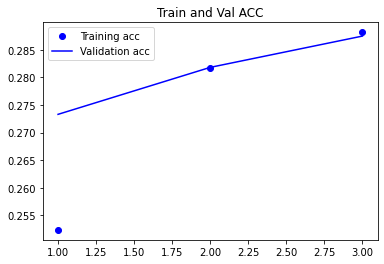

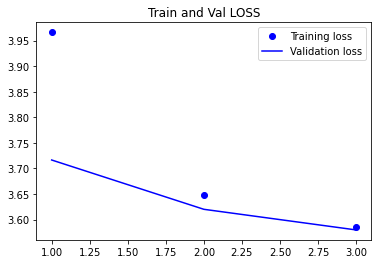

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = "Training acc")
plt.plot(epochs, val_acc, 'b', label = "Validation acc")
plt.title("Train and Val ACC")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Train and Val LOSS")

plt.legend()

plt.show()

# Assessing the results



Write a function that generates text

generate some text and take note of
 - token repetitions
 - missing punctuations
 - other anomalies



In [0]:
# generate words

def generate_words(model, tokenizer, seq_len, seed_text, n_words, vocab_size):
  
  input_text = list(seed_text.split(" "))
  
  for i in range(n_words):
    seq = tokenizer.texts_to_sequences([input_text])
    
    seq = pad_sequences(seq, maxlen = seq_len)
    y_pred = model.predict_classes([seq], verbose  = 0)
    word = index2word[y_pred[0]]

    input_text.append(word)
	
  return ' '.join(input_text)

In [0]:
# generate some sentences

In [0]:
seed_text = 'how'
generate_words(model, tokenizer, seq_len, seed_text, 10, vocab_size) 

'how can i do this <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

In [0]:
seed_text = 'I'
generate_words(model, tokenizer, seq_len, seed_text, 10, vocab_size)

"I ' m not sure what you mean by <UNK> <UNK>"

In [0]:
seed_text = 'what is the best'
generate_words(model, tokenizer, seq_len, seed_text, 10, vocab_size)

'what is the best way to do this <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

In [0]:
seed_text = 'how many'
generate_words(model, tokenizer, seq_len, seed_text, 10, vocab_size)

'how many <UNK> are you <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

In [0]:
seed_text = 'another way to'
generate_words(model, tokenizer, seq_len, seed_text, 10, vocab_size)

'another way to do this <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

----


Write a function that calculates perplexity of a sentence and apply it to a subset of sentences to evaluate the model.



In [0]:
# TO DO

Define a validation set, for instance 1000 titles
Transform that validation set into sequences of tokens using the training vocabulary



Tune the neural net and the parameters of the pre processing phase to improve perplexity score of the model.